In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from PIL import Image

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet121
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive

In [2]:
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/images/training'
valid_path = '/content/drive/MyDrive/images/valid'

Mounted at /content/drive


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_aug.flow_from_directory(
    valid_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1750 images belonging to 3 classes.
Found 305 images belonging to 3 classes.


In [4]:
def build_radimagenet(input_shape=(224, 224, 3), num_classes=3):
    base = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    base.load_weights('/content/drive/MyDrive/RadImageNet-ResNet50_notop.h5')

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(3, activation='softmax')(x)

    return models.Model(inputs=base.input, outputs=predictions)


In [5]:
def build_efficientnet(input_shape=(224, 224, 3), num_classes=3):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis = -1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l2=0.001),activity_regularizer=regularizers.l1(l1=0.006),
                bias_regularizer=regularizers.l1(l1=0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)
    output=Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, output)


In [6]:
def build_chexnet(input_shape=(224, 224, 3), num_classes=3):
    base_model = DenseNet121(include_top=False, weights=None, input_shape=input_shape)
    base_model.load_weights('/content/drive/MyDrive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5', by_name=True, skip_mismatch=True)

    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
def compile_and_train(model, train_gen, val_gen, name):
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early = EarlyStopping(patience=3, restore_best_weights=True)

    checkpoint_cb = ModelCheckpoint(
        filepath=f'{name}_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        save_weights_only=False,
        verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[early, checkpoint_cb]
    )

    model.save(f'{name}_model.h5')
    return history


In [8]:
radimagenet = build_radimagenet()
radimagenet_hist = compile_and_train(radimagenet, train_gen, val_gen, 'radimagenet')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4428 - loss: 1.0454 
Epoch 1: val_accuracy improved from -inf to 0.35410, saving model to radimagenet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 1166s 20s/step - accuracy: 0.4442 - loss: 1.0442 - val_accuracy: 0.3541 - val_loss: 1.0757
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6760 - loss: 0.7432
Epoch 2: val_accuracy improved from 0.35410 to 0.62951, saving model to radimagenet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 599ms/step - accuracy: 0.6764 - loss: 0.7427 - val_accuracy: 0.6295 - val_loss: 0.7808
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7463 - loss: 0.5799
Epoch 3: val_accuracy improved from 0.62951 to 0.66557, saving model to radimagenet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.7464 - loss: 0.5797 - val_accuracy: 0.6656 - val_loss: 0.7441
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8184 - loss: 0.4761
Epoch 4: val_accuracy did not improve from 0.66557
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 566ms/step - accuracy: 0.8183 - loss: 0.4761 - val_accuracy: 0.3639 - val_loss: 2.2714
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8166 - loss: 0.4441
Epoch 5: val_accuracy improved from 0.66557 to 0.71148, saving model to radimagenet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 606ms/step - accuracy: 0.8168 - loss: 0.4439 - val_accuracy: 0.7115 - val_loss: 0.6310
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8394 - loss: 0.3955
Epoch 6: val_accuracy improved from 0.71148 to 0.80984, saving model to radimagenet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.8394 - loss: 0.3955 - val_accuracy: 0.8098 - val_loss: 0.5095
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8630 - loss: 0.3624
Epoch 7: val_accuracy did not improve from 0.80984
55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 612ms/step - accuracy: 0.8631 - loss: 0.3623 - val_accuracy: 0.7082 - val_loss: 0.8129
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8676 - loss: 0.3377
Epoch 8: val_accuracy improved from 0.80984 to 0.85246, saving model to radimagenet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 601ms/step - accuracy: 0.8675 - loss: 0.3378 - val_accuracy: 0.8525 - val_loss: 0.3843
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.8706 - loss: 0.3080
Epoch 9: val_accuracy did not improve from 0.85246
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.8706 - loss: 0.3080 - val_accuracy: 0.7705 - val_loss: 0.6527
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.8789 - loss: 0.2992
Epoch 10: val_accuracy did not improve from 0.85246
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8789 - loss: 0.2994 - val_accuracy: 0.8000 - val_loss: 0.5556


In [9]:
efficientnet = build_efficientnet()
efficientnet_hist = compile_and_train(efficientnet, train_gen, val_gen, 'efficientnet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4687 - loss: 23.8407
Epoch 1: val_accuracy improved from -inf to 0.32787, saving model to efficientnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4693 - loss: 23.7803 - val_accuracy: 0.3279 - val_loss: 4.4035
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.4812 - loss: 8.7066
Epoch 2: val_accuracy did not improve from 0.32787
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 536ms/step - accuracy: 0.4808 - loss: 8.6665 - val_accuracy: 0.3279 - val_loss: 2.8645
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.4421 - loss: 3.0612
Epoch 3: val_accuracy did not improve from 0.32787
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.4416 - loss: 3.0561 - val_accuracy: 0.3279 - val_loss: 3.4542
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.4063 - loss: 2.2337
Epoch 4: val_accuracy improved from 0.32787 to 0.34426, saving model to efficientnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.4062 - loss: 2.2324 - val_accuracy: 0.3443 - val_loss: 2.7293
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4029 - loss: 1.8348
Epoch 5: val_accuracy did not improve from 0.34426
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.4028 - loss: 1.8349 - val_accuracy: 0.3443 - val_loss: 1.7282
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.4108 - loss: 1.7025
Epoch 6: val_accuracy did not improve from 0.34426
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.4109 - loss: 1.7017 - val_accuracy: 0.3443 - val_loss: 1.7214
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.4454 - loss: 1.6005
Epoch 7: val_accuracy did not improve from 0.34426
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 520ms/step - accuracy: 0.4451 - loss: 1.6005 - val_accuracy: 0.3443 - val_loss: 1.7007
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4255 - loss: 1.5861
Epoch 8: val_accuracy improved 

55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 534ms/step - accuracy: 0.4256 - loss: 1.5873 - val_accuracy: 0.3705 - val_loss: 1.6622
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.4466 - loss: 1.6002
Epoch 9: val_accuracy did not improve from 0.37049
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 523ms/step - accuracy: 0.4462 - loss: 1.6001 - val_accuracy: 0.3443 - val_loss: 1.6217
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.4019 - loss: 1.5722
Epoch 10: val_accuracy did not improve from 0.37049
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 513ms/step - accuracy: 0.4024 - loss: 1.5721 - val_accuracy: 0.3443 - val_loss: 1.5939


In [10]:
chexnet = build_chexnet()
chexnet_hist = compile_and_train(chexnet, train_gen, val_gen, 'chexnet')

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3206 - loss: 1.1995
Epoch 1: val_accuracy improved from -inf to 0.34426, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.3213 - loss: 1.1989 - val_accuracy: 0.3443 - val_loss: 1.1235
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.4232 - loss: 1.0850
Epoch 2: val_accuracy did not improve from 0.34426
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 563ms/step - accuracy: 0.4228 - loss: 1.0853 - val_accuracy: 0.3443 - val_loss: 1.1159
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.4195 - loss: 1.1025
Epoch 3: val_accuracy did not improve from 0.34426
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 587ms/step - accuracy: 0.4196 - loss: 1.1023 - val_accuracy: 0.3443 - val_loss: 1.1142
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.4755 - loss: 1.0366
Epoch 4: val_accuracy improved from 0.34426 to 0.39672, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 588ms/step - accuracy: 0.4754 - loss: 1.0365 - val_accuracy: 0.3967 - val_loss: 1.1226
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.5189 - loss: 0.9820
Epoch 5: val_accuracy did not improve from 0.39672
55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.5191 - loss: 0.9817 - val_accuracy: 0.3934 - val_loss: 1.0996
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.5547 - loss: 0.9023
Epoch 6: val_accuracy improved from 0.39672 to 0.46230, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 595ms/step - accuracy: 0.5550 - loss: 0.9020 - val_accuracy: 0.4623 - val_loss: 1.0412
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.6461 - loss: 0.8214
Epoch 7: val_accuracy improved from 0.46230 to 0.49508, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 618ms/step - accuracy: 0.6458 - loss: 0.8213 - val_accuracy: 0.4951 - val_loss: 0.9817
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6817 - loss: 0.7472
Epoch 8: val_accuracy improved from 0.49508 to 0.55738, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 617ms/step - accuracy: 0.6816 - loss: 0.7472 - val_accuracy: 0.5574 - val_loss: 0.8613
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6884 - loss: 0.6936
Epoch 9: val_accuracy improved from 0.55738 to 0.63934, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 618ms/step - accuracy: 0.6880 - loss: 0.6940 - val_accuracy: 0.6393 - val_loss: 0.7330
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6935 - loss: 0.6774
Epoch 10: val_accuracy improved from 0.63934 to 0.65902, saving model to chexnet_best_model.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.6936 - loss: 0.6772 - val_accuracy: 0.6590 - val_loss: 0.7446


In [11]:
print("Train class indices:", train_gen.class_indices)
print("Validation class indices:", val_gen.class_indices)

Train class indices: {'Healthy': 0, 'Moderate': 1, 'Severe': 2}
Validation class indices: {'Healthy': 0, 'Moderate': 1, 'Severe': 2}


In [12]:
def plot_history(history_dict):
    plt.figure(figsize=(14, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, hist in history_dict.items():
        plt.plot(hist.history['accuracy'], label=f'{name} Train')
        plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for name, hist in history_dict.items():
        plt.plot(hist.history['loss'], label=f'{name} Train')
        plt.plot(hist.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
import matplotlib.pyplot as plt

def plot_all_model_histories(history_dict, val = False):
    """
    Plots training and validation accuracy/loss for multiple models on a single plot.

    Parameters:
    - history_dict: Dictionary of model_name -> history object from model.fit()
    """

    plt.figure(figsize=(16, 6))

    # ----------------- ACCURACY ----------------- #
    plt.subplot(1, 2, 1)
    for model_name, hist in history_dict.items():
        if val:
          plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{model_name} - Val')
          plt.title('Validation Accuracy')
        else:
          plt.plot(hist.history['accuracy'], label=f'{model_name} - Train')
          plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # ----------------- LOSS ----------------- #
    plt.subplot(1, 2, 2)
    for model_name, hist in history_dict.items():
        if val:
            plt.plot(hist.history['val_loss'], linestyle='--', label=f'{model_name} - Val')
            plt.title('Validation Loss')
        else:
            plt.plot(hist.history['loss'], label=f'{model_name} - Train')
            plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.suptitle("Model Training Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [15]:
history_dict = {
    'RadImageNet': radimagenet_hist,
    'CheXNet': chexnet_hist,
    'EfficientNet': efficientnet_hist
}

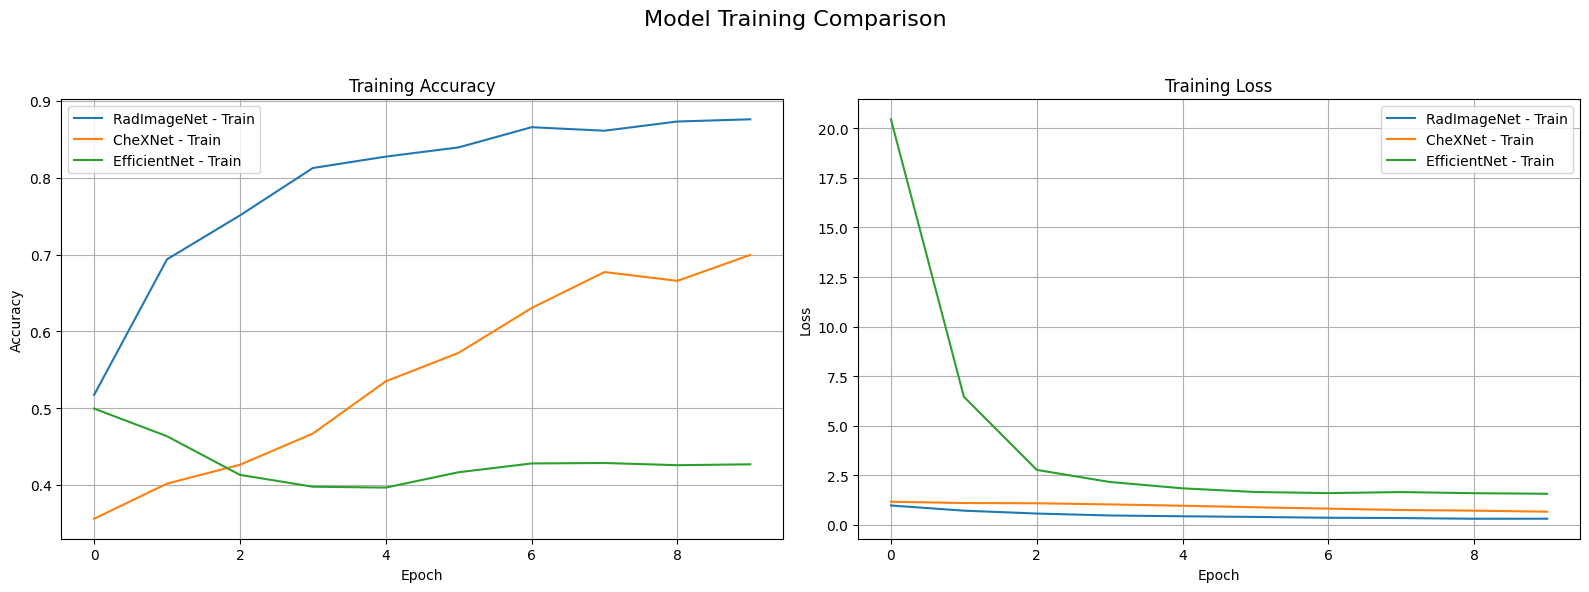

In [20]:
plot_all_model_histories(history_dict)


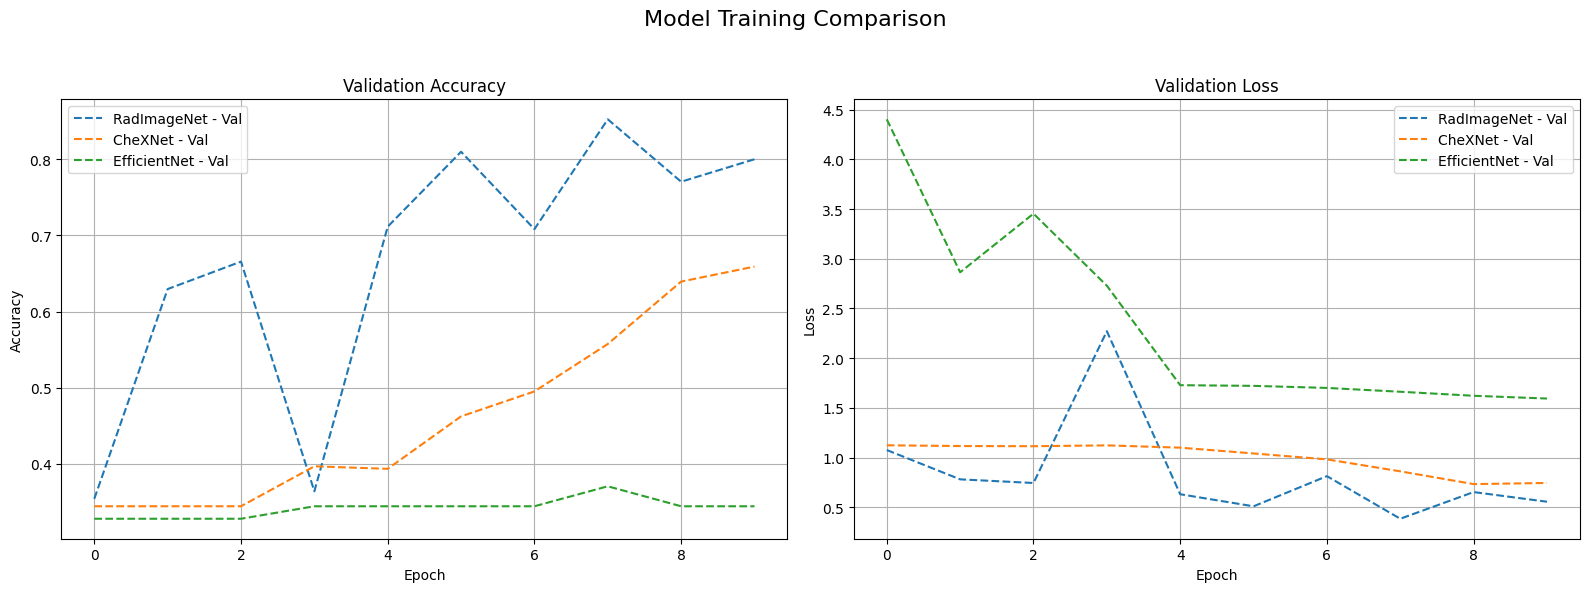

In [21]:
plot_all_model_histories(history_dict, val=True)